In [2]:
# ! pip install sklearn
# !pip install neo
# !pip install elephant

# general imports 
import allensdk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# set data path
import sys
import platform
import os
from os.path import join as pjoin
from pathlib import Path
import time

sys.path.insert(0, '/code/src')
import importlib
import plot_utils
# reload it after edits
importlib.reload(plot_utils)
# from data_utils import process_nwb_metadata, get_stim_window, get_spike_counts_all
from plot_utils import create_raster, plot_area_psth_and_raster
# from classifier import get_classifier, run_classifier
from matplotlib.lines import Line2D


from neo.core import SpikeTrain
from quantities import ms, s, Hz
from elephant.statistics import time_histogram, instantaneous_rate,  mean_firing_rate
from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_correlation import cross_correlation_histogram


from data_utils import process_nwb_metadata, get_stim_window, get_spike_counts_all
from plot_utils import plot_area_psth_and_raster, plot_multi_area_psth_and_raster, build_area_packet

# Set paths + import data tables from AllenSDK

In [3]:
platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_dir = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_dir = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_dir = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_dir = "/media/$USERNAME/Brain2025/"
data_root = Path(data_dir)
print('data directory set to', data_dir)

data directory set to /data/


In [4]:
# Visual Behavior Neuropixels 
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

cache_dir = '/root/capsule/data/'

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(
            cache_dir=cache_dir, use_static_cache=True)

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Visual Behavior Neuropixels 
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

cache_dir = '/root/capsule/data/'

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(
            cache_dir=cache_dir, use_static_cache=True)

In [6]:
behaviour_session_table = cache.get_behavior_session_table() # row per session
ecephys_session_table = cache.get_ecephys_session_table() 
probe_table = cache.get_probe_table() 
channel_table = cache.get_channel_table() 
unit_table = cache.get_unit_table() 

In [ ]:
behaviour_session_table['session_type']

In [23]:
behaviour_session_table['session_type']columns

Index(['equipment_name', 'genotype', 'mouse_id', 'sex', 'age_in_days',
       'session_number', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'ecephys_session_id', 'date_of_acquisition', 'session_type',
       'image_set', 'file_id'],
      dtype='object')

## BEHAVIOR

In [8]:
# pynwb is for reading python NWB files
import pynwb

beh_path = '/data/visual-behavior-neuropixels/behavior_ecephys_sessions/1043752325/ecephys_session_1043752325.nwb'
session = pynwb.NWBHDF5IO(beh_path).read()

# alternative way to get the session
# session = cache.get_behavior_session(1040882886)

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [49]:
# dir(session) # get all the atributes of the session
# _running_speed # get_rolling_performance_df # get_reward_rate

In [29]:
session.get_rolling_performance_df() # reward_rate >2 engaged # get_reward_rate

,reward_rate,hit_rate_raw,hit_rate,false_alarm_rate_raw,false_alarm_rate,rolling_dprime
trials_id,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
707,0.736545,NaN,NaN,NaN,NaN,NaN
708,0.783471,0.149425,0.149425,0.0,0.038462,0.729924
709,0.841188,0.149425,0.149425,0.0,0.038462,0.729924


In [ ]:
# beh_path = '/data/visual-behavior-neuropixels/behavior_only_sessions/' #behavior_ecephys_sessions
# session_names= behaviour_session_table.index.unique() # list with the session names

# sess_list =[]

# # loop to extract the each beh session trials table and concatenate as df (1 row per trial)
# for sess in session_names:
#     folder_path= beh_path + sess + '/behavior_session_'+ sess+ '.nwb'
#     sess_file = pynwb.NWBHDF5IO(beh_path).read()
#     trials_file = sess_file.trials.to_dataframe()
#     trials_file = trials_file.reset_index(names='trial') # make a specific colum for trial index
#     trials_file['session_number'] = sess # include the column session (useful to merge later with behaviour_session_table)
#     # trials_file['mouse_id'] = # include the column mouse_id


## EPHYS

In [7]:
print(ecephys_session_table.image_set.unique())
print(ecephys_session_table.prior_exposures_to_image_set.unique())
print(ecephys_session_table.experience_level.unique())
# abnormal_histology; abnormal_activity

['G' 'H']
<IntegerArray>
[30,  0, 62, 51, 56, 32, 26, 46, 34, 15, 22, 17, 41, 19, 20, 23, 18, 24, 21,
 33, 38, 37, 36, 27, 49, 45, 29, 31, 69, 42, 16]
Length: 31, dtype: Int64
['Familiar' 'Novel']


### To do list

->1 per session activity matrix hline rian region  
->all mice together

-> 20 units per region of all sessins: 
- psth aligned to image presentation (sort by novelty)
- psth aligned to image change  (sort by novelty)
- psth aligned to response
- autocorrelogram
- resters over session

Experimental gorups
- Train on G; see G on first recording day; see H on second recording day
- Train on G; see H on first recording day; see G on second recording day
- Train on H; see H on first recording day; see G on second recording day

### Sort by novel session

In [9]:
novel_sessions=ecephys_session_table.loc[ecephys_session_table['experience_level']=='Novel'] # session_type
novel_sessions.groupby('mouse_id')['behavior_session_id'].unique().shape

# get indexes of sessions
novel_sessions_bids = novel_sessions.behavior_session_id.unique() # behavioral ids of sessions
novel_sessions_eids = novel_sessions.index                        # ephys ids of sessions

### Select a single session

In [10]:
a_novel_session_id = novel_sessions_eids[0] # from ephys ids
a_novel_session = cache.get_ecephys_session(ecephys_session_id=a_novel_session_id)

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [11]:
# Extract spike times and stimulus presentations times of this session
spike_times_dic = a_novel_session.spike_times
stimulus_presentations = a_novel_session.stimulus_presentations

In [12]:
# Get some behavioral timesamps and features
stim_onsets_arr = stimulus_presentations[stimulus_presentations['active']]['start_time'].values
stim_type_arr =   stimulus_presentations[stimulus_presentations['active']]['image_name'].values
stim_novelty_arr =stimulus_presentations[stimulus_presentations['active']]['is_image_novel'].values
change_times_arr = stimulus_presentations[stimulus_presentations['active']]['is_change']

change_times = stimulus_presentations[stimulus_presentations['active']&
                            stimulus_presentations['is_change']]['start_time'].values # always use stimulus_presentations['start_time'] contains the delay
                            # a_novel_session.stimulus_timestamps doesn't contain the image display deay thats why the clocks are different

# how to get the responses timestamps 
# get if trial was hit or false alarm

In [10]:
# many stimulus presentations but only 200 changes
print(stimulus_presentations.shape)
print(change_times.shape)

(13401, 24)
(200,)


### Select the unit

In [13]:
#Good units filter
units = a_novel_session.get_units()
channels = a_novel_session.get_channels()
unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True)
good_unit_filter = ((unit_channels['snr']>1)&
                    (unit_channels['isi_violations']<1)&
                    (unit_channels['firing_rate']>0.1))
good_units = unit_channels.loc[good_unit_filter]
good_units_list= good_units.index # get names of good units 

In [13]:
good_units.groupby("structure_acronym").apply(lambda g: g.index.unique())

structure_acronym
CA1      Int64Index([1053043669, 1053043496, 1053043475...
CA3      Int64Index([1053044185, 1053044184, 1053044168...
DG       Int64Index([1053043723, 1053043406, 1053043367...
HPF      Int64Index([1053044091, 1053043955, 1053043954...
LP       Int64Index([1053043322, 1053043314, 1053043346...
MB       Int64Index([1053044083, 1053043859, 1053043852...
MGd      Int64Index([1053044760, 1053044767, 1053044768...
MGm      Int64Index([1053044705, 1053044713, 1053045055...
MGv      Int64Index([1053044740, 1053044719, 1053044746...
MRN      Int64Index([1053043842, 1053043815, 1053043839...
PIL      Int64Index([1053044694, 1053044692, 1053044700...
POL      Int64Index([1053043293, 1053043288, 1053043273...
POST     Int64Index([1053043910, 1053043902, 1053043901...
PP       Int64Index([1053045348, 1053045102, 1053045104...
SCig     Int64Index([1053043875, 1053043874, 1053043872...
SNr      Int64Index([1053045097], dtype='int64', name='...
TH       Int64Index([1053045054, 10530

In [82]:
# Select the unit
unit = 1053044101 #good_units_list[0]
spike_times= spike_times_dic[unit] #timestamps of the specific unit
unit_channels.loc[unit_channels.index==unit]['structure_acronym'].unique() # check the brain region

array(['VISp'], dtype=object)

In [ ]:
# PLOT

In [83]:
# Define a stimulus window.
pre_window  = .2 # How far before the stimulus should we look?
post_window = .75 # How far after the stimulus should we look?
bin_size = .01 # What size bins do we want for our PSTH?
bins = np.arange(-pre_window,post_window+bin_size,bin_size) # Set up bins
bin_centers = bins[:-1]+bin_size/2
# Storage for data.
triggered_spike_times = []
triggered_stim_index = []
# Loop through the stimuli!!
for i, stim_time in enumerate(stim_onsets_arr):
    # Select spikes that fall within the time window around this stimulus
    mask = ((spike_times >= stim_time - pre_window) & 
            (spike_times < stim_time + post_window))
    
    # Align spike times to stimulus onset (0 = stimulus)
    trial_spikes = spike_times[mask] - stim_time

    triggered_spike_times.append(trial_spikes)
    triggered_stim_index.append(np.ones(len(trial_spikes))*i) # trial index

# triggered_spike_times now has the times of each spike per trial.  
print(triggered_spike_times[:3])
# triggered_trial_index is for keeping track of which trial this spike was from
print(triggered_stim_index[:3])


# For plotting, we are going to want to concatenate these data into one big vector
triggered_spike_times = np.concatenate(triggered_spike_times)
triggered_stim_index = np.concatenate(triggered_stim_index)

[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]


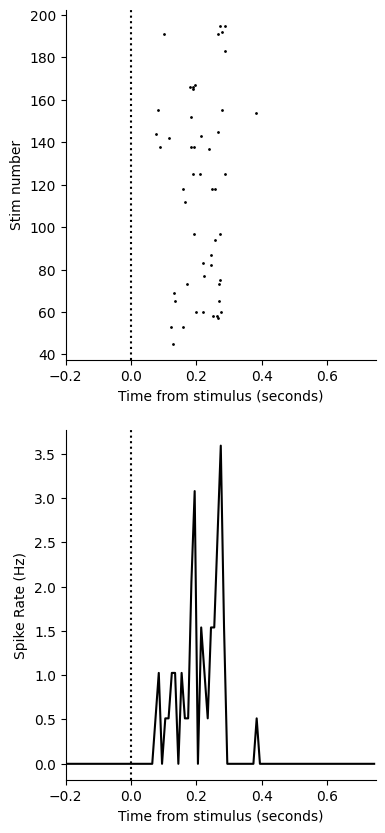

In [94]:
# Instantiate a plot
fig,ax = plt.subplots(nrows = 2,figsize =(4,10))

# Plot the raster! Its just dots, so we use scatter.
# The 'k' here is a shoutout to all the matlab users...
ax[0].scatter(triggered_spike_times,triggered_stim_index,s = 1,c = 'k')
ax[0].set_xlabel('Time from stimulus (seconds)')
ax[0].set_ylabel('Stim number')
ax[0].axvline([0],c = 'black', linestyle=':')
ax[0].set_xlim(-pre_window, post_window)
# remove top and right axes
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# and make the histogram.
a,b = np.histogram(triggered_spike_times,bins = bins)
# Divide by # of trials, then bin size to get a rate estimate in Spikes/Sec = Hz
a = a/np.max(triggered_stim_index)/bin_size
ax[1].plot(bin_centers,a,c = 'k')
ax[1].axvline([0],c = 'black', linestyle=':')
ax[1].set_xlabel('Time from stimulus (seconds)')
ax[1].set_ylabel('Spike Rate (Hz)')
ax[1].set_xlim(-pre_window, post_window)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

In [113]:
valid_mask = ~pd.isna(stim_type_arr)   # True where stim_type is not NaN
valid_trials = np.where(valid_mask)[0]
stim_type_arr_valid = stim_type_arr[valid_mask]


# order by stimulus type
unique_stim = np.unique(stim_type_arr_valid) # unique stimulus types

trial_order = np.concatenate([
    np.where((stim_type_arr == s) & valid_mask)[0]       # original trial indices (valid only)
    for s in unique_stim])


# old trial index -> new  index after ordering
old_to_new = {old: new for new, old in enumerate(trial_order)}

# keep only spikes from valid trials, remap y to the new order
valid_spike_mask = np.isin(triggered_stim_index, valid_trials)
spike_times_valid = triggered_spike_times[valid_spike_mask]
trial_idx_valid   = triggered_stim_index[valid_spike_mask].astype(int)
new_y = np.array([old_to_new[t] for t in trial_idx_valid])

# Assign a color to each stim_type
cmap = plt.get_cmap("tab10")
type_to_color = {t: cmap(i % 10) for i, t in enumerate(unique_stim)}
spike_colors = np.array([type_to_color[stim_type_arr[t]] for t in trial_idx_valid])


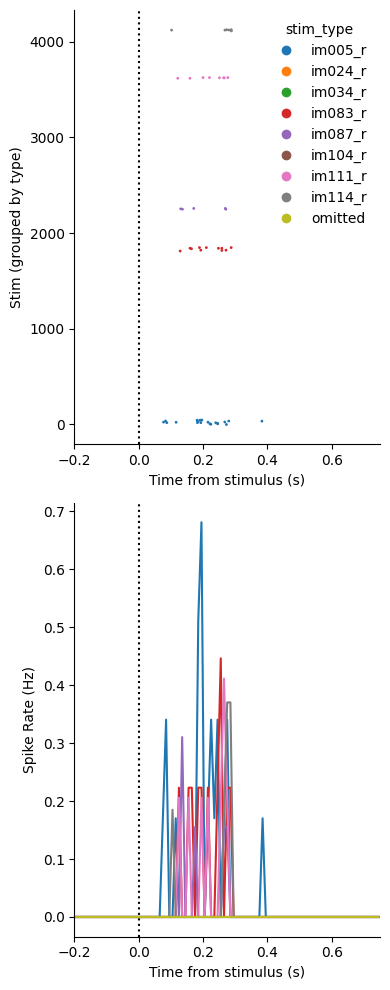

In [117]:
# make a mapping from "old trial index" -> "new row index"
fig, ax = plt.subplots(nrows=2, figsize=(4, 10))

# Raster plot (spikes)
ax[0].scatter(spike_times_valid, new_y, s=1, c=spike_colors)
ax[0].set_xlabel("Time from stimulus (s)")
ax[0].set_ylabel("Stim (grouped by type)")
ax[0].axvline(0, color="black", linestyle=":")
ax[0].set_xlim(-pre_window, post_window)
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)

# Add a legend for stim types
legend_elements = [
    Line2D([0], [0], marker="o", linestyle="", color=color, label=str(t))
    for t, color in type_to_color.items()
]
ax[0].legend(handles=legend_elements, title="stim_type", frameon=False)

# Histogram 
bin_size = np.diff(bins)[0]
bin_centers = (bins[:-1] + bins[1:]) / 2

for s in unique_stim:
    trials_s = np.where(stim_type_arr == s)[0]
    # spikes from these trials
    mask_s = np.isin(trial_idx_valid, trials_s)
    spike_times_s = spike_times_valid[mask_s]

    # histogram for this type
    counts, _ = np.histogram(spike_times_s, bins=bins)
    rate = counts / len(trials_s) / bin_size

    ax[1].plot(bin_centers, rate, color=type_to_color[s], label=str(s))

ax[1].axvline(0, c="black", linestyle=":")
ax[1].set_xlabel("Time from stimulus (s)")
ax[1].set_ylabel("Spike Rate (Hz)")
ax[1].set_xlim(-pre_window, post_window)
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)

plt.tight_layout()

#### Autocorr

In [129]:
# create a spike train 0 and 1
spiketrain = SpikeTrain(spike_times * 1000 * ms,
                            t_stop=spike_times.max() * 1000 * ms,
                            t_start=spike_times.min() * 1000 * ms)

bin_size, sdev, autocorr_win,  = 1, 50, 60, # Convolution parameters (ms)

In [134]:
def generate_autocorr_data(spiketrain, bin_size, autocorr_win):
    binned_spiketrain = BinnedSpikeTrain([spiketrain], bin_size=bin_size * ms)
    autocorr, bins_auto = cross_correlation_histogram(binned_spiketrain, binned_spiketrain, window=[-int(autocorr_win), int(autocorr_win)])
    autocorr_array, bins_auto = np.delete(autocorr.magnitude.flatten(), bins_auto == 0), np.delete(bins_auto, bins_auto == 0)
    return bins_auto, autocorr_array

bins_auto, autocorr_array = generate_autocorr_data(spiketrain, bin_size+1, autocorr_win)

#plot
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))
ax.bar(bins_auto, autocorr_array, width=1, color='gray', linewidth=0.3)
ax.axvspan(-2, 2, color='orange', alpha=0.2) # refractory period (isi)
ax.set_xlabel('Time (ms)') #
ax.axvline(2, color='black', linewidth=0.2)
ax.axvline(-2, color='black', linewidth=0.2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

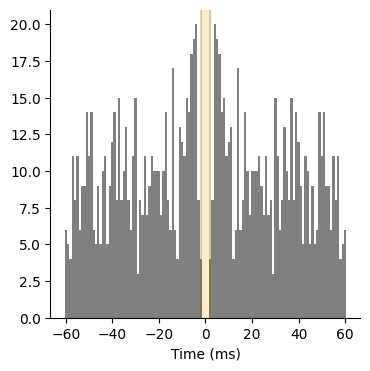

In [139]:
#plot
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))
ax.bar(bins_auto, autocorr_array, width=1, color='gray', linewidth=0.3)
ax.axvspan(-2, 2, color='orange', alpha=0.2) # refractory period (isi)
ax.set_xlabel('Time (ms)') #
ax.axvline(2, color='black', linewidth=0.2)
ax.axvline(-2, color='black', linewidth=0.2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

## Population analysis

1. Bin all units on a common time grid,
2. Sum across units to get a population spike-count vector per bin, and
3. Autocorrelate that summed vector.

In [14]:
good_units = good_units.sort_values('probe_vertical_position', ascending=False)
good_units.structure_acronym.unique()

array(['VISl', 'VISp', 'VISrl', 'VISal', 'root', 'HPF', 'CA1', 'VISpm',
       'POST', 'DG', 'CA3', 'SCig', 'MB', 'MRN', 'MGd', 'MGv', 'LP',
       'MGm', 'PIL', 'POL', 'TH', 'PP', 'SNr'], dtype=object)

In [15]:
# brain areas
visual_cortex= ['VISp', 'VISl', 'VISal', 'VISpm', 'VISrl'] # primary, lateral, anterolateral, posteromedial, rostorlateral
hippocampus = ['HPF', 'CA1', 'CA3', 'DG', 'POST','PP']  #  dentate gyrus, umbrella,  postsubiculum, parasubiculum, 
thalamus =  ['MGd','MGv', 'MGm', 'LP', 'PIL',  'POL', 'TH']   #general, lateralposterior, posterior intralaminar, medial division, dorsal division, posterior thalamic nucleus
midbrain = ['SCig', 'MB',  'MRN', 'SNr'] #superior colliculus  midbrain reticular nucleus, midbrain umbrella, #substantia nigra,

In [19]:
# spike_times = a_novel_session.spike_times # all spike times of the session
# area_packets = [build_area_packet(a, good_units, spike_times, sort_key='depth') for a in visual_cortex]

In [16]:
for region in visual_cortex:
    units_region= good_units.loc[good_units['structure_acronym']==region]
    spike_times_region= []  # list of 1D arrays per unit
    print(region)
    print('Nº of units ' +str(units_region.shape[0]))
    print('')

    for unit in units_region.index: #get spike times for each unit of the region
        spike_times= spike_times_dic[unit] #timestamps of the specific unit
        spike_times_region.append(spike_times)  
    break

VISp
Nº of units 97



In [41]:
# bin_size_ms=1.0

# tic=time.time()
# units = [np.asarray(st, float) for st in spike_times_region if len(st) > 0]

# # check the max and min spiketimes coonsidering all units of the region
# t_start = min(s.min() for s in units)
# t_stop  = max(s.max() for s in units)
    
# # wrap each unit into a Neo SpikeTrain
# spiketrains = [SpikeTrain(u * s, t_start=t_start * s, t_stop=t_stop * s) for u in units]


# # bin spiketrains of all units and  create a single array
# binsize = (bin_size_ms / 1000.0) * s
# binned_spiketrain = BinnedSpikeTrain(spiketrains, bin_size=binsize, t_start=t_start * s, t_stop=t_stop * s) # matrix n_units × n_bins
# counts = np.asarray(binned_spiketrain.to_array()).sum(axis=0).astype(float)  # Collapsing all units into one population vector n_bins

# tac=time.time()

# print(tac-tic)


0.7003917694091797


/opt/conda/lib/python3.9/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


In [19]:
spike_times[-1]

9719.458768352293

In [22]:

# spike_times_list_ms: list of 1D arrays, each in milliseconds

def population_autocorr(spike_times_list, bin_size_ms=1.0, max_lag_ms=250.0):
    # spike_times_list: list of 1D arrays, each in milliseconds
    
    spikes = [np.asarray(st, float) for st in spike_times_list if len(st) > 0]
    if not spikes:
        return np.array([]), np.array([])
    
    spikes_ms = [np.round(s * 1000.0).astype(np.int64) for s in spikes]
    t_start = min(i.min() for i in spikes_ms)
    t_stop  = max(i.max() for i in spikes_ms)
    if t_stop <= t_start:
        return np.array([]), np.array([])
    
    # Histogram all spikes at once
    edges = np.arange(t_start, t_stop + bin_size_ms + 1, bin_size_ms, dtype=np.int64)
    all_spikes_ms = np.concatenate(spikes_ms)
    counts, _ = np.histogram(all_spikes_ms, bins=edges)
    
    #  Optional normalization to highlight oscillations
    if zscore:
        mu, sig = x.mean(), x.std()
        x = (x - mu) / sig if sig > 0 else x - mu

    
    # FFT autocorrelation 
    x = counts.astype(float)
    n = x.size
    nfft = 1 << (2*n - 1).bit_length() # pad to a fast length ~>= 2n
    Xf = np.fft.rfft(x, n=nfft)
    Sxx = Xf * np.conj(Xf)
    ac_full = np.fft.irfft(Sxx)[:2*n - 1]
    
    # Build lag axis in ms and crop to ±max_lag_ms
    # Each bin represents 'bin_size_ms' milliseconds
    lags_bins_full = np.arange(-n + 1, n)              # in bins
    lags_ms_full   = lags_bins_full * bin_size_ms      # convert to ms

    keep = (lags_ms_full >= -max_lag_ms) & (lags_ms_full <= max_lag_ms)
    lags_ms = lags_ms_full[keep]
    ac = ac_full[keep]

    # Hide the giant zero-lag peak (optional)
    if zero_lag_to_zero and lags_ms.size:
        ac[np.argmin(np.abs(lags_ms))] = 0.0
        
    return lags_ms, ac


tic= time.time()
lags_ms, ac = population_autocorr(spike_times_region[:3],
                                             bin_size_ms=1.0,
                                             max_lag_ms=200.0)  # or None
tac= time.time()
print(tac-tic)


NameError: name 'zero_lag_to_zero' is not defined

In [ ]:
# plot
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(lags_ms, ac, lw=1)
ax.axvline(0, color='k', linestyle=':')
ax.set_xlabel('Lag (ms)')
ax.set_ylabel('Autocorr (z-scored)' if 'zacf' else 'Autocorr (counts)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [156]:
spike_times

array([5.85009517e+00, 6.37879580e+00, 8.78353198e+00, ...,
       9.71422697e+03, 9.71549764e+03, 9.71597147e+03])

In [ ]:
def population_acg_elephant(spike_times_list,            # list of 1D arrays (seconds) — one per unit
                            bin_size_ms=1.0,             # ms
                            max_lag_ms=200.0,            # ms (half-window)
                            t_start_s=None, t_stop_s=None,
                            zero_lag_to_zero=True,
                            normalize='none'):           # 'none' or 'zacf' (zero-mean, unit-variance ACF)
    
    # 1) wrap in SpikeTrains with common t_start/t_stop
    if t_start_s is None:
        t_start_s = min([np.min(st) for st in spike_times_list if len(st) > 0])
    if t_stop_s is None:
        t_stop_s  = max([np.max(st) for st in spike_times_list if len(st) > 0])

    sts = [neo.SpikeTrain(np.asarray(st, float) * pq.s,
                          t_start=t_start_s * pq.s,
                          t_stop=t_stop_s * pq.s)
           for st in spike_times_list]

    # 2) bin all trains on the same grid
    binsize = (bin_size_ms/1000.0) * pq.s
    bst = BinnedSpikeTrain(sts, binsize=binsize, t_start=t_start_s * pq.s, t_stop=t_stop_s * pq.s)
    # (units x bins) sparse matrix -> sum across units -> population counts per bin
    pop_counts = np.asarray(bst.to_array().sum(axis=0)).ravel()  # shape (n_bins,)

    # 3) autocorrelation (full) on counts
    ac_full = np.correlate(pop_counts, pop_counts, mode='full').astype(float)
    n = pop_counts.size
    lags_ms_full = (np.arange(2*n - 1) - (n - 1)) * bin_size_ms

    # 4) keep ±max_lag
    keep = (lags_ms_full >= -max_lag_ms) & (lags_ms_full <= max_lag_ms)
    lags_ms = lags_ms_full[keep]
    ac = ac_full[keep]

    # 5) optionally zero-out the zero-lag bin (often huge)
    if zero_lag_to_zero:
        zero_idx = np.argmin(np.abs(lags_ms))
        ac[zero_idx] = 0.0

    # 6) normalization (optional)
    if normalize == 'zacf':
        # correlation of (x-mean) with itself (approximate ACF, unit variance at lag 0)
        x = pop_counts.astype(float)
        x = x - x.mean()
        denom = (x.var() * x.size) if x.var() > 0 else 1.0
        ac_full = np.correlate(x, x, mode='full') / denom
        ac = ac_full[keep]
        if zero_lag_to_zero:
            ac[zero_idx] = 0.0

    return lags_ms, ac

# -------- Example: group by brain region and overlay --------
# Suppose you have: a dict region -> list_of_units, where each unit is a 1D array of spike times in seconds
# e.g. region_spikes = {"ALM": [unit1_times, unit2_times, ...], "S1": [...], ...}

def plot_population_acg_by_region(region_spikes, bin_size_ms=1.0, max_lag_ms=200.0, normalize='none'):
    plt.figure(figsize=(6,4))
    for i, (region, units) in enumerate(region_spikes.items()):
        if len(units) == 0: 
            continue
        lags_ms, ac = population_acg_elephant(units, bin_size_ms, max_lag_ms, normalize=normalize)
        plt.plot(lags_ms, ac, label=f'{region}')
    plt.axvline(0, color='k', linestyle=':')
    plt.xlabel('Lag (ms)')
    ylabel = 'Autocorr (counts)' if normalize=='none' else 'Autocorr (z-scored)'
    plt.ylabel(ylabel)
    plt.title('Population ACG by region')
    plt.legend(frameon=False)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()


In [ ]:
# Select the unit
unit = 1053044101 #good_units_list[0]
spike_times= spike_times_dic[unit] #timestamps of the specific unit
unit_channels.loc[unit_channels.index==unit]['structure_acronym'].unique() # check the brain region